In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
! pip install neuralprophet[live]
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from datetime import date, datetime, timedelta
import seaborn as sns
import pickle
import holidays
from neuralprophet import NeuralProphet, set_random_seed, save, load



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Load Data

In [79]:
DATA_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Merged"
MODEL_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Model/Saved_Model"
FORECAST_DIR = "/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Forecast"

In [80]:
NYC = pd.read_csv(f"{DATA_DIR}/full_merge_v3.csv", index_col = 0)
NYC = NYC.rename({'Time Stamp': 'ds', 'N.Y.C.': 'y'}, axis = 1)
NYC['ds'] = pd.to_datetime(NYC.ds)
NYC = NYC.drop(labels = ['CAPITL', 'CENTRL', 'DUNWOD', 'GENESE', 'LONGIL', 'MHK VL', 
                   'HUD VL', 'MILLWD', 'NORTH', 'WEST', 'NYCA', 
                   'month', 'day', 'hour', 'minute', 'PeriodEnd', 'PeriodStart',
                   'Period', 'datetime','dow_x','dow_y'], axis = 1)



In [81]:
NYC

,ds,y,year,AirTemp,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,...,PrecipitableWater,RelativeHumidity,SnowWater,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,AlbedoDaily,HourlyDryBulbTemperature,HourlyRelativeHumidity
0,2017-01-01 00:00:00,5116.9000,2017,6.8,1.0,76.4,-4.8,0.0,0.0,0.0,...,14.5,43.5,0.0,1011.9,226.0,7.0,162.0,0.12,44.000000,51.0
1,2017-01-01 00:05:00,5102.1000,2017,6.8,-3.0,76.4,-4.8,0.0,0.0,0.0,...,14.5,43.5,0.0,1011.9,227.0,7.0,162.0,0.13,44.000000,51.0
2,2017-01-01 00:10:00,5074.9000,2017,6.8,-7.0,76.4,-4.7,0.0,0.0,0.0,...,14.5,43.5,0.0,1011.9,227.0,7.0,162.0,0.13,44.000000,51.0
3,2017-01-01 00:15:00,5089.6000,2017,6.8,-11.0,76.4,-4.7,0.0,0.0,0.0,...,14.5,43.5,0.0,1011.9,228.0,7.0,162.0,0.13,44.000000,51.0
4,2017-01-01 00:20:00,5061.3000,2017,6.9,-14.0,76.4,-4.7,0.0,0.0,0.0,...,14.5,43.5,0.0,1011.9,228.0,7.0,162.0,0.13,44.000000,51.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631003,2022-12-31 23:35:00,4749.6870,2022,8.6,19.0,89.7,8.5,0.0,0.0,0.0,...,27.5,99.2,0.0,1014.8,252.0,2.5,162.0,0.10,48.451613,100.0
631004,2022-12-31 23:40:00,4738.3370,2022,8.6,16.0,88.2,8.5,0.0,0.0,0.0,...,27.2,99.2,0.0,1014.7,251.0,2.4,162.0,0.10,48.290323,100.0
631005,2022-12-31 23:45:00,4731.2676,2022,8.5,12.0,86.5,8.4,0.0,0.0,0.0,...,26.9,99.2,0.0,1014.6,250.0,2.4,162.0,0.10,48.129032,100.0
631006,2022-12-31 23:50:00,4721.4570,2022,8.5,8.0,85.0,8.4,0.0,0.0,0.0,...,26.6,99.2,0.0,1014.5,249.0,2.3,162.0,0.10,48.500000,100.0


In [82]:
train =  NYC[NYC.ds < '2022-1-1']
val = NYC.loc[len(train)-36:, ] #include last 18 point from 2021 so can make prediction for early 2022
val

,ds,y,year,AirTemp,Azimuth,CloudOpacity,DewpointTemp,Dhi,Dni,Ebh,...,PrecipitableWater,RelativeHumidity,SnowWater,SurfacePressure,WindDirection10m,WindSpeed10m,Zenith,AlbedoDaily,HourlyDryBulbTemperature,HourlyRelativeHumidity
525852,2021-12-31 21:00:00,5134.3193,2021,9.5,79.0,65.6,7.3,0.0,0.0,0.0,...,19.1,86.2,0.0,1021.4,192.0,2.1,138.0,0.11,48.180000,99.46
525853,2021-12-31 21:05:00,5152.0070,2021,9.5,78.0,69.3,7.3,0.0,0.0,0.0,...,19.2,86.2,0.0,1021.3,191.0,2.2,139.0,0.11,48.280000,99.16
525854,2021-12-31 21:10:00,5153.6836,2021,9.5,77.0,64.0,7.3,0.0,0.0,0.0,...,19.2,86.4,0.0,1021.3,191.0,2.2,140.0,0.11,48.380000,98.86
525855,2021-12-31 21:15:00,5144.9805,2021,9.4,76.0,60.3,7.3,0.0,0.0,0.0,...,19.2,86.5,0.0,1021.3,190.0,2.2,141.0,0.11,48.480000,98.56
525856,2021-12-31 21:20:00,5130.7990,2021,9.4,75.0,66.9,7.3,0.0,0.0,0.0,...,19.3,86.7,0.0,1021.3,190.0,2.3,142.0,0.11,48.580000,98.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631003,2022-12-31 23:35:00,4749.6870,2022,8.6,19.0,89.7,8.5,0.0,0.0,0.0,...,27.5,99.2,0.0,1014.8,252.0,2.5,162.0,0.10,48.451613,100.00
631004,2022-12-31 23:40:00,4738.3370,2022,8.6,16.0,88.2,8.5,0.0,0.0,0.0,...,27.2,99.2,0.0,1014.7,251.0,2.4,162.0,0.10,48.290323,100.00
631005,2022-12-31 23:45:00,4731.2676,2022,8.5,12.0,86.5,8.4,0.0,0.0,0.0,...,26.9,99.2,0.0,1014.6,250.0,2.4,162.0,0.10,48.129032,100.00
631006,2022-12-31 23:50:00,4721.4570,2022,8.5,8.0,85.0,8.4,0.0,0.0,0.0,...,26.6,99.2,0.0,1014.5,249.0,2.3,162.0,0.10,48.500000,100.00


In [83]:
print(train.shape) # quick check to see if the size of data is expected. 
print(val.shape)

(525888, 23)
(105156, 23)


In [84]:
def get_cols(cols = None, train = train, val= val):
  col_requested = ['ds', 'y']
  if cols: 
    col_requested += cols
  return train[col_requested] , val[col_requested]



In [85]:
def RRMSE(true, pred):
    num = np.sum(np.square(true - pred))
    den = np.sum(np.square(pred))
    squared_error = num/den
    rrmse_loss = np.sqrt(squared_error)
    return rrmse_loss
trainer_config = {"accelerator":"gpu"}

In [86]:
t = int(365*24*(60/5))-18
actual_load=NYC.iloc[-t:]['y']
trainer_config = {"accelerator":"gpu"}


# Model with Holiday and weather 


In [87]:
holiday_dict = {} 
for year in range(2017,2024):
  holiday_dict.update(holidays.US(state='NY', years=year))


df_holiday = pd.DataFrame.from_dict({datetime.combine(dt, datetime.min.time()) + timedelta(hours=5*i/60): 'holiday'
      for dt, hol in holiday_dict.items() for i in range(int(60/5*24)) }, orient = 'index')\
      .reset_index()\
      .rename({'index':'ds', 0:'event'}, axis = 1)

In [88]:
feature_columns = ['HourlyDryBulbTemperature', 'Dni']
REG_PARAM = 0.8

m_h_w_f = NeuralProphet(n_lags=18,
                      n_forecasts = 18,
                      yearly_seasonality=True, 
                      weekly_seasonality=True, 
                      daily_seasonality=True,
                      num_hidden_layers = 1,
                      epochs = 20, 
                      trainer_config = trainer_config)

m_h_w_f = m_h_w_f.add_events(['holiday'], mode='multiplicative', regularization = REG_PARAM)
m_h_w_f = m_h_w_f.add_lagged_regressor(names = feature_columns, regularization = REG_PARAM) 
for col in feature_columns:
  m_h_w_f = m_h_w_f.add_future_regressor(f'{col}_f', mode='multiplicative', regularization = REG_PARAM) 
m_h_w_f = m_h_w_f.highlight_nth_step_ahead_of_each_forecast(18)


INFO - (NP.forecaster.add_lagged_regressor) - n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (18)
INFO:NP.forecaster:n_lags = 'auto', number of lags for regressor is set to Autoregression number of lags (18)


In [89]:
set_random_seed(2023)
train_w, val_w = get_cols(feature_columns)
for col in feature_columns:
  train_w[f'{col}_f']= train_w[col]
  val_w[f'{col}_f']= val_w[col]

train_w = m_h_w_f.create_df_with_events(train_w, df_holiday)
val_w = m_h_w_f.create_df_with_events(val_w, df_holiday)

WARNING - (py.warnings._showwarnmsg) - <ipython-input-89-0e197abfa0c8>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


WARNING - (py.warnings._showwarnmsg) - <ipython-input-89-0e197abfa0c8>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy




A

In [90]:
set_random_seed(2023)
m_h_w_f_metric = m_h_w_f.fit(train_w,
                          validation_df = val_w,
                          freq='5min')
m_h_w_f_metric

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 100.0% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 100.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO:NP.config:Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 128
INFO:NP.config:Auto-set batch_size to 128


Finding best initial lr:   0%|          | 0/293 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,142.177948,177.174515,0.000746,0.0,0,1648.152222,2084.924072,0.124589,0.0
1,62.315052,81.904442,0.000160,0.0,1,90.154381,120.851723,0.000263,0.0
2,84.012291,105.723244,0.000273,0.0,2,68.988617,92.705353,0.000148,0.0
3,152.055832,181.209641,0.000948,0.0,3,80.000664,104.812843,0.000192,0.0
4,110.794685,135.975876,0.000459,0.0,4,88.061295,114.004028,0.000228,0.0
5,122.272430,149.715942,0.000566,0.0,5,94.309044,121.281807,0.000260,0.0
6,166.353882,194.635544,0.001050,0.0,6,94.270134,121.127548,0.000261,0.0
7,97.683701,120.889297,0.000356,0.0,7,91.061249,117.226494,0.000242,0.0
8,91.997665,115.211052,0.000322,0.0,8,88.415215,114.087402,0.000228,0.0
9,81.099792,102.274727,0.000249,0.0,9,85.010948,110.146538,0.000213,0.0


In [91]:
forecast_h_w_f_raw = m_h_w_f.predict(val_w, raw = True)
forecast_h_w_f = m_h_w_f.predict(val_w)
fig = m_h_w_f.plot(forecast_h_w_f)


WARNING - (NP.forecaster.predict) - Raw forecasts are incompatible with plotting utilities
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min


Predicting: 4109it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min
INFO - (NP.df_utils._infer_frequency) - Major frequency 5T corresponds to 99.999% of the data.
INFO:NP.df_utils:Major frequency 5T corresponds to 99.999% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 5min
INFO:NP.df_utils:Defined frequency is equal to major frequency - 5min


Predicting: 4109it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO:NP.df_utils:Returning df with no ID column
WARNING - (NP.plotting.log_warning_resampler_switch_to_valid_env) - Warning: plotly-resampler not supported for the environment you are using. Plotting backend automatically switched to 'plotly' without resampling 


WARNING - (NP.plotting.log_warning_deprecation_plotly) - DeprecationWarning: default plotting_backend will be changed to plotly in a future version. Switch to plotly by calling `m.set_plotting_backend('plotly')`.


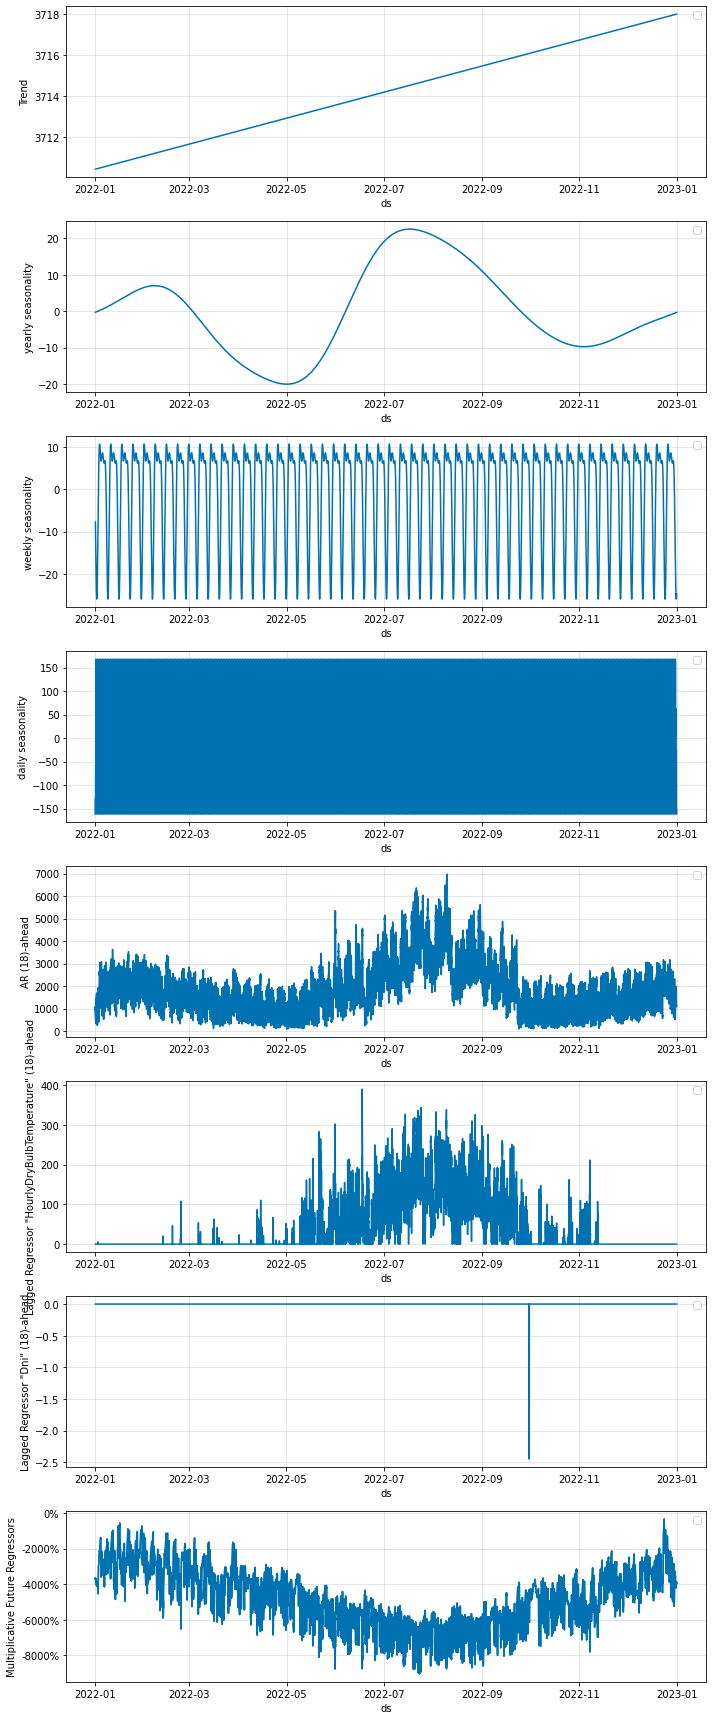

In [92]:
comp = m_h_w_f.plot_components(forecast_h_w_f, plotting_backend = 'matplotlib')


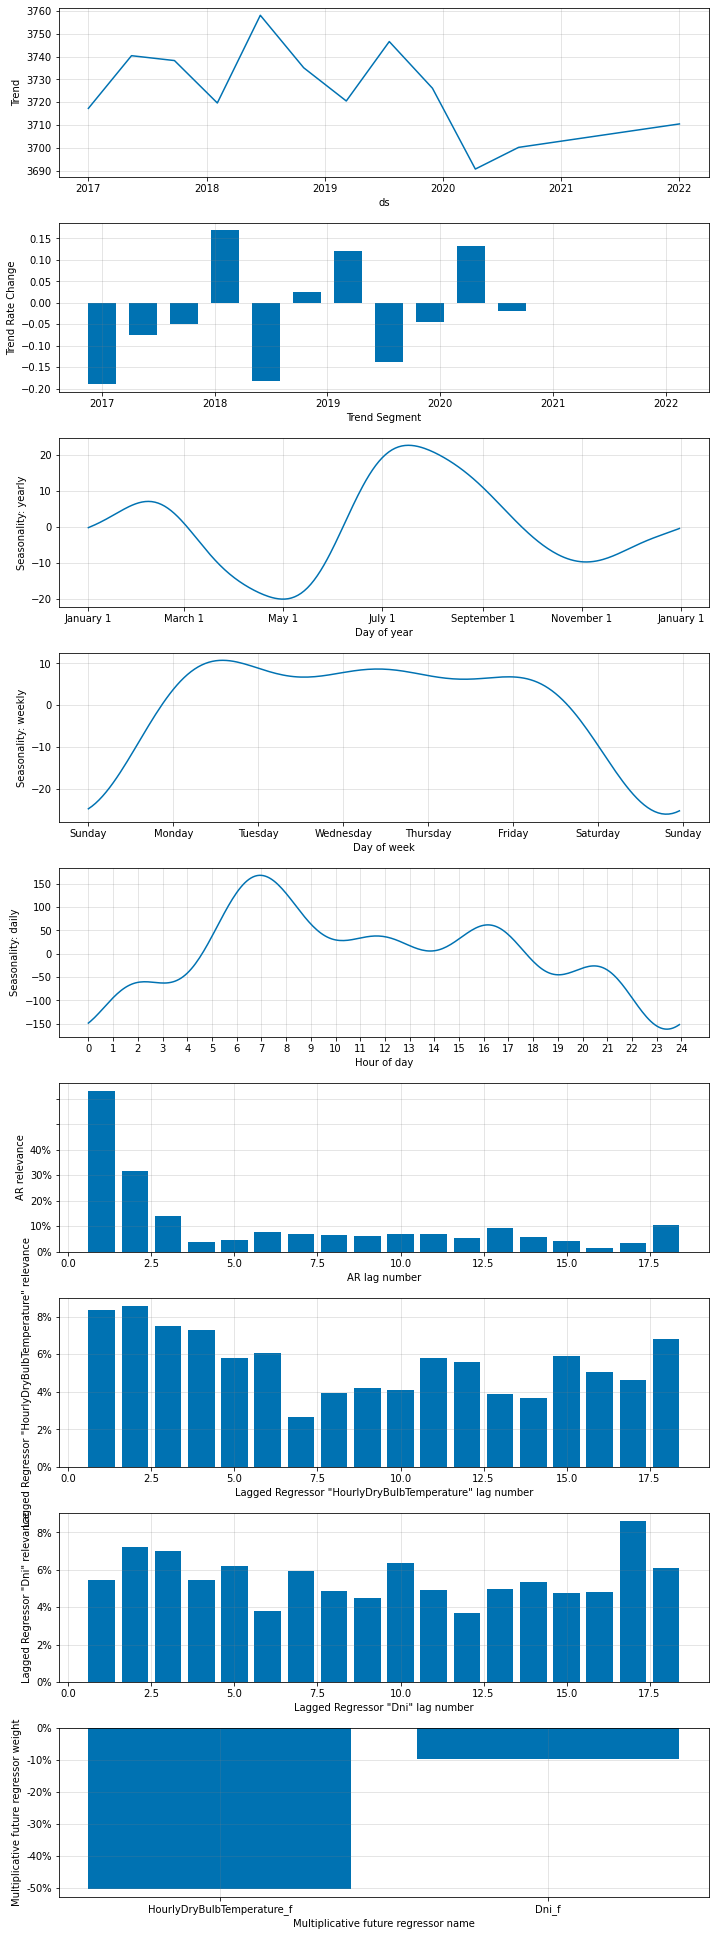

In [93]:
m_h_w = m_h_w_f.highlight_nth_step_ahead_of_each_forecast()

param = m_h_w_f.plot_parameters(plotting_backend = 'default')


In [100]:
RRMSE(np.array(forecast_h_w_f[36:-18]['y']), np.array(forecast_h_w_f[36:-18]['yhat17']))


0.017034464989132497

In [101]:
forecast_h_w_f_raw.to_csv(f'{FORECAST_DIR}/neuralprophet_h_w_f_raw.csv')
forecast_h_w_f.to_csv(f'{FORECAST_DIR}/neuralprophet_h_w_f.csv')
save(m_h_w_f, f"{MODEL_DIR}/neuralphrophet_h_w_f.np")


In [118]:
forecast_h_w_f['error17'] = forecast_h_w_f['yhat17'] - forecast_h_w_f['y']
error

0                NaN
1                NaN
2                NaN
3                NaN
4                NaN
             ...    
105151   -121.536121
105152   -124.616785
105153   -145.138694
105154    -98.732391
105155           NaN
Length: 105156, dtype: float64

<AxesSubplot:>

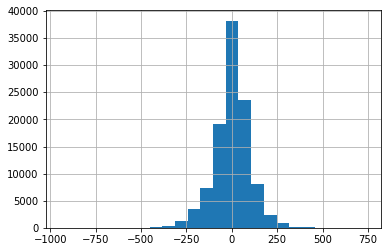

In [119]:
forecast_h_w_f['error17'].hist(bins = 24)

<AxesSubplot:>

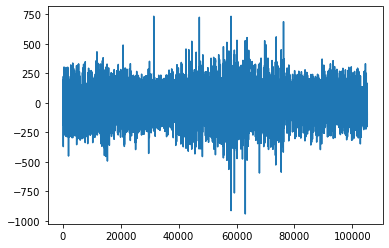

In [131]:
forecast_h_w_f['error17'].plot()

In [128]:
val_w.loc[forecast_h_w_f['error17'].idxmax()]

ds                            2022-04-19 21:55:00
y                                       5140.7065
HourlyDryBulbTemperature                     44.0
Dni                                           0.0
HourlyDryBulbTemperature_f                   44.0
Dni_f                                         0.0
holiday                                       0.0
Name: 31403, dtype: object

In [129]:
val_w.loc[forecast_h_w_f['error17'].idxmin()]

ds                            2022-08-07 16:45:00
y                                        8747.661
HourlyDryBulbTemperature                     83.0
Dni                                         706.0
HourlyDryBulbTemperature_f                   83.0
Dni_f                                       706.0
holiday                                       0.0
Name: 63021, dtype: object

In [135]:
errors = forecast_h_w_f[['ds', 'y', 'yhat17', 'error17']].dropna().rename({'ds':'Time Stamp'})

errors.to_csv("/content/drive/MyDrive/Capstone_Grid_Load_Forecasting/Data/Errors/NP_90min.csv")

In [140]:
forecast_h_w_f_raw['event_holiday17'].dropna().mean()

-0.64345133